# SFCA and RAAM script tests at Middle Layer Super Output Areas (MSOA) level using OSRM distance (30 miles threshold)

In [1]:
from access import access, weights, datasets
import logging
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl
import seaborn as sns
import numpy as np
from scipy import stats

# Data import

## Get LA——MSOA code data

In [2]:
LA_MSOA = pd.read_csv('LA_MSOA_code.csv')
LA_MSOA

LA_Code_2020 LA_name_2020  MSOA Code
0       E06000001   Hartlepool  E02002483
1       E06000001   Hartlepool  E02002484
2       E06000001   Hartlepool  E02002485
3       E06000001   Hartlepool  E02002487
4       E06000001   Hartlepool  E02002488
...           ...          ...        ...
6786    E09000033  Westminster  E02000979
6787    E09000033  Westminster  E02000980
6788    E09000033  Westminster  E02000981
6789    E09000033  Westminster  E02000982
6790    E09000033  Westminster  E02000983

[6791 rows x 3 columns]

## Get MSOA boundary data

In [18]:
MSOA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
MSOA = MSOA.to_crs('epsg:27700')

<AxesSubplot:>

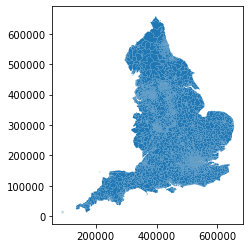

In [5]:
MSOA.plot()

## Get the population weighted centroid of MSOA (demand points)

In [3]:
MSOA_points=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Population_Weighted_Centroids_with_population.gpkg?raw=true')
MSOA_points = MSOA_points.to_crs('epsg:27700')

<AxesSubplot:>

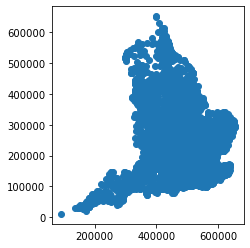

In [7]:
MSOA_points.plot()

### Calculate population over 60

In [4]:
MSOA_points['pop60+69'] = MSOA_points['pop60-69']

In [6]:
MSOA_points

objectid   msoa11cd  pop0-49  pop50-59  pop60-69  pop70-79  pop80-89  \
0            1  E02002536     5688      1416      1132       891       540   
1            2  E02002537     5578      1251       836       545       386   
2            3  E02002534     2547       824       863       967       407   
3            4  E02002535     4959      1636      1385       870       416   
4            5  E02002532     3783       970       810       655       342   
...        ...        ...      ...       ...       ...       ...       ...   
6786      6787  E02004669     3697      1171      1156       946       433   
6787      6788  E02006096     3893      1086       805       804       344   
6788      6789  E02003088     4007      1257      1230      1194       577   
6789      6790  E02006070     5161      1163       906       670       316   
6790      6791  E02006679     6429      1744      1408      1177       560   

      pop90+  total_pop                       geometry  pop60+69  
0        104       9771  POINT (445582.345 524175.434)      1132  
1         45       8641  POINT (446777.151 524256.841)       836  
2         85       5693  POINT (461356.929 515118.900)       863  
3         70       9336  POINT (446117.027 525455.836)      1385  
4         95       6655  POINT (461053.212 516175.379)       810  
...      ...        ...                            ...       ...  
6786      93       7496  POINT (393469.114 227500.260)      1156  
6787      69       7001  POINT (332829.367 109219.836)       805  
6788     179       8444  POINT (343276.340 158947.520)      1230  
6789      75       8291  POINT (331710.269 136880.200)       906  
6790      96      11414  POINT (390561.555 162786.953)      1408  

[6791 rows x 11 columns]

## read vaccination site point data (supply points)

In [5]:
site = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/site_2_26_clean/vaccination_site.gpkg?raw=true')
site = site.to_crs('epsg:27700')

<AxesSubplot:>

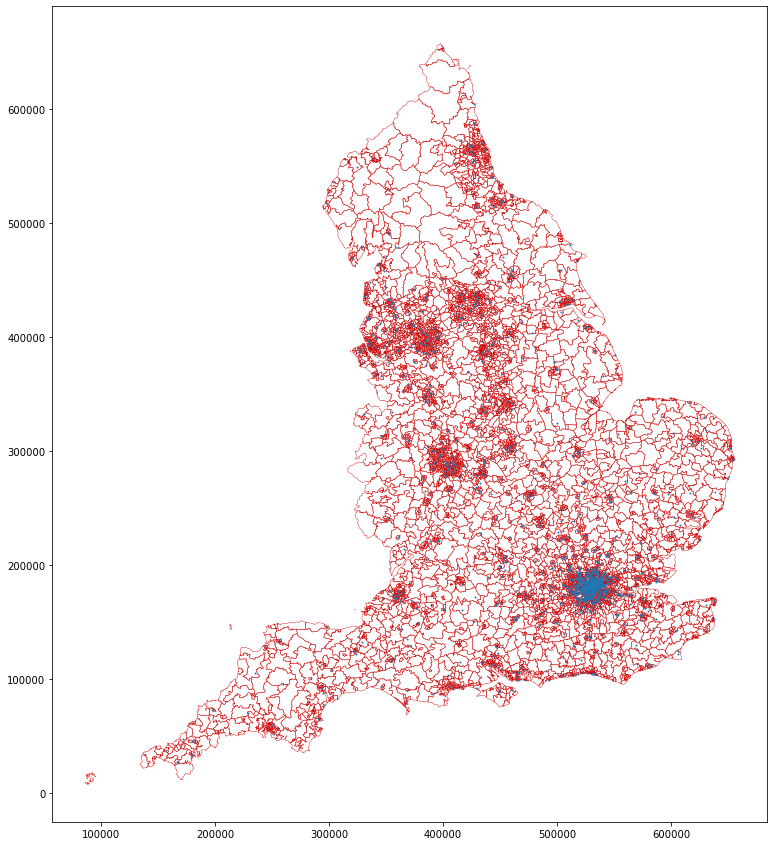

In [8]:
f,ax = plt.subplots(figsize=(15,15))
MSOA.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=0.5,ax=ax)
site.plot(ax=ax,markersize=1)

In [9]:
site

index  supply_value                       geometry
0         0             1  POINT (504748.029 248914.642)
1         1             1  POINT (505059.230 222903.988)
2         2             1  POINT (532504.110 176066.629)
3         3             1  POINT (532504.110 176066.629)
4         4             1  POINT (504396.617 222557.941)
...     ...           ...                            ...
1595   1595             1   POINT (196928.058 72385.978)
1596   1596             1  POINT (524814.936 172019.963)
1597   1597             1  POINT (526813.753 181129.037)
1598   1598             1   POINT (408626.628 90816.439)
1599   1599             1  POINT (324002.981 121792.829)

[1600 rows x 3 columns]

# Read in the driving distance from the point of demand to the point of supply as cost

In [6]:
distance_cost_df = pd.read_csv('distance_cost_final_OSRM.csv') 
distance_cost_df = distance_cost_df.rename(columns={"Distance in meter": "cost", "origin_id": "origin", "destination_id": "dest"})
distance_cost_df

cost     origin  dest
0         6712.7  E02002536   122
1        56619.8  E02002536   123
2        51152.7  E02002536   126
3        13881.2  E02002536   127
4        50625.1  E02002536   128
...          ...        ...   ...
1674418  48512.4  E02006679  1458
1674419  43150.5  E02006679  1460
1674420  26966.3  E02006679  1591
1674421  49329.1  E02006679  1592
1674422  60462.9  E02006679  1593

[1674423 rows x 3 columns]

# Calculate the MSOAs that have no vaccination service within 10 miles distance and plot the map

In [11]:
# Get demand MSOAs that have at least one vaccination site within 10 miles of distance
distance_cost_df_test = distance_cost_df.loc[distance_cost_df['cost']<16093.44]
distance_cost_df_test

a = pd.unique(distance_cost_df_test['origin'])

# Set 'MSOA_with_supply' field True if a place has at least one vaccination site within 10 miles of distance, otherwise False.
b = pd.DataFrame()
b['MSOA'] = a
b['MSOA_with_supply'] = True

MSOA_with_supply = pd.merge(left = MSOA,right = b, how='left', left_on='MSOA11CD', right_on='MSOA')
MSOA_with_supply=MSOA_with_supply.fillna(False)

### Count the number of MSOAs that are lack of vaccination service

In [12]:
m = MSOA_with_supply[MSOA_with_supply['MSOA_with_supply']==False]
print('There are ',m['MSOA11CD'].count(),'MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.')

There are  383 MSOAs that are lack of vaccination service setting 10 miles as the vaccination service radius threshold.


### Plot the regions that are lack of service

In [13]:
# Get the boundary of England
MSOA_with_supply['dissolve']=1
MSOA_outline = MSOA_with_supply.dissolve(by='dissolve')

Text(0.5, 1.0, 'MSOAs Lack of Vaccination Service')

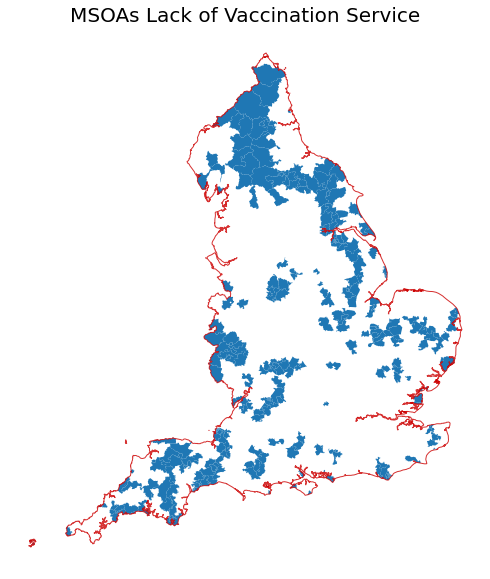

In [14]:
# Plot the map
f,ax = plt.subplots(figsize=(10,10))
m.plot(figsize = (10,10),ax=ax)
MSOA_outline.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1,ax=ax)
ax.axis('off')
ax.set_title('MSOAs Lack of Vaccination Service', fontdict={'fontsize':'20', 'fontweight':'3'})

# Create a dataframe for the accessibility calculation using the Driving distance from the point of demand to the point of supply as cost

In [7]:
fca = access(demand_df = MSOA_points,
           demand_index='msoa11cd',
           demand_value='pop60+69',
           supply_df= site,
           supply_index= 'index',
           supply_value=['supply_value'],
           cost_df              = distance_cost_df,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'cost',
           neighbor_cost_df     = distance_cost_df,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'cost')

### 2SFCA

In [8]:
# Using 2SFCA method, 16093.44 meters (10 miles) is used as service threshold radius to calculate the accessibility
fca.two_stage_fca(name = "2sfca_10",max_cost = 16093.44)
fca.two_stage_fca(name = "2sfca_15",max_cost = 24140.16)
fca.two_stage_fca(name = "2sfca_20",max_cost = 32186.88)
fca.two_stage_fca(name = "2sfca_25",max_cost = 40233.60)
fca.two_stage_fca(name = "2sfca_30",max_cost = 48280.32)

2sfca_30_supply_value
msoa11cd                        
E02000001               0.001005
E02000002               0.001001
E02000003               0.000997
E02000004               0.000955
E02000005               0.000980
...                          ...
E02006930               0.000971
E02006931               0.000999
E02006932               0.000135
E02006933               0.000132
E02006934               0.000135

[6791 rows x 1 columns]

### E2SFCA

#### Set distance decay weight using gaussian function.

In [9]:
# Define a gaussian weight. Here, set the σ to be 5364.48 (meters), which is one third of the threshold, such that we'll be at the 3σ level at 16093.44 meters.
# 用3σ原理解释参数的选择 (According to the the empirical rule, also referred to as the three-sigma rule,
# for a normal distribution, almost all observed data will fall within three standard deviations.因此当距离接近threshold时，weight趋近于0)
gaussian_10 = weights.gaussian(sigma =5364.48)
gaussian_15 = weights.gaussian(sigma =8064.72)
gaussian_20 = weights.gaussian(sigma =10728.96)
gaussian_25 = weights.gaussian(sigma =13411.20)
gaussian_30 = weights.gaussian(sigma =16093.44)

fca.enhanced_two_stage_fca(name = "E2sfca_10", weight_fn = gaussian_10)
fca.enhanced_two_stage_fca(name = "E2sfca_15", weight_fn = gaussian_15)
fca.enhanced_two_stage_fca(name = "E2sfca_20", weight_fn = gaussian_20)
fca.enhanced_two_stage_fca(name = "E2sfca_25", weight_fn = gaussian_25)
fca.enhanced_two_stage_fca(name = "E2sfca_30", weight_fn = gaussian_30)

E2sfca_30_supply_value
msoa11cd                         
E02000001                0.001665
E02000002                0.000698
E02000003                0.000726
E02000004                0.000612
E02000005                0.000752
...                           ...
E02006930                0.001331
E02006931                0.001405
E02006932                0.000176
E02006933                0.000158
E02006934                0.000167

[6791 rows x 1 columns]

### 3SFCA

In [10]:
fca.three_stage_fca(name = "3sfca_10", weight_fn = gaussian_10)

3sfca_10_supply_value
msoa11cd                        
E02000001               0.002644
E02000002               0.000402
E02000003               0.000446
E02000004               0.000308
E02000005               0.000449
...                          ...
E02006930               0.001224
E02006931               0.001311
E02006932               0.000101
E02006933               0.000074
E02006934               0.000102

[6791 rows x 1 columns]

In [11]:
fca.three_stage_fca(name = "3sfca_15", weight_fn = gaussian_15)

3sfca_15_supply_value
msoa11cd                        
E02000001               0.002012
E02000002               0.000574
E02000003               0.000608
E02000004               0.000486
E02000005               0.000626
...                          ...
E02006930               0.001305
E02006931               0.001372
E02006932               0.000104
E02006933               0.000089
E02006934               0.000100

[6791 rows x 1 columns]

In [12]:
fca.three_stage_fca(name = "3sfca_20", weight_fn = gaussian_20)

3sfca_20_supply_value
msoa11cd                        
E02000001               0.001673
E02000002               0.000687
E02000003               0.000702
E02000004               0.000583
E02000005               0.000706
...                          ...
E02006930               0.001275
E02006931               0.001331
E02006932               0.000117
E02006933               0.000105
E02006934               0.000108

[6791 rows x 1 columns]

In [13]:
fca.three_stage_fca(name = "3sfca_25", weight_fn = gaussian_25)

3sfca_25_supply_value
msoa11cd                        
E02000001               0.001484
E02000002               0.000734
E02000003               0.000747
E02000004               0.000633
E02000005               0.000752
...                          ...
E02006930               0.001234
E02006931               0.001274
E02006932               0.000125
E02006933               0.000116
E02006934               0.000116

[6791 rows x 1 columns]

In [14]:
fca.three_stage_fca(name = "3sfca_30", weight_fn = gaussian_30)

3sfca_30_supply_value
msoa11cd                        
E02000001               0.001366
E02000002               0.000757
E02000003               0.000772
E02000004               0.000672
E02000005               0.000782
...                          ...
E02006930               0.001187
E02006931               0.001217
E02006932               0.000133
E02006933               0.000125
E02006934               0.000126

[6791 rows x 1 columns]

### Rational agent access model (RAAM)

In [15]:
fca.raam(name = "raam", tau = 16093.44);

## See the result

In [15]:
fca.access_df

pop60+69  2sfca_10_supply_value  2sfca_15_supply_value  \
msoa11cd                                                            
E02000001      1025               0.002110               0.001588   
E02000002       505               0.000397               0.000585   
E02000003       886               0.000392               0.000680   
E02000004       598               0.000276               0.000495   
E02000005       629               0.000386               0.000709   
...             ...                    ...                    ...   
E02006930       473               0.001573               0.001365   
E02006931       672               0.001757               0.001403   
E02006932       173               0.000184               0.000144   
E02006933       485               0.000173               0.000128   
E02006934       216               0.000115               0.000136   

           2sfca_20_supply_value  2sfca_25_supply_value  \
msoa11cd                                                  
E02000001               0.001263               0.001109   
E02000002               0.000917               0.000997   
E02000003               0.000955               0.001000   
E02000004               0.000882               0.000988   
E02000005               0.000996               0.000992   
...                          ...                    ...   
E02006930               0.001194               0.001064   
E02006931               0.001217               0.001075   
E02006932               0.000208               0.000160   
E02006933               0.000171               0.000160   
E02006934               0.000207               0.000160   

           2sfca_30_supply_value  E2sfca_10_supply_value  \
msoa11cd                                                   
E02000001               0.001005                0.003061   
E02000002               0.001001                0.000336   
E02000003               0.000997                0.000383   
E02000004               0.000955                0.000254   
E02000005               0.000980                0.000390   
...                          ...                     ...   
E02006930               0.000971                0.001373   
E02006931               0.000999                0.001540   
E02006932               0.000135                0.000139   
E02006933               0.000132                0.000093   
E02006934               0.000135                0.000113   

           E2sfca_15_supply_value  E2sfca_20_supply_value  \
msoa11cd                                                    
E02000001                0.002470                0.002103   
E02000002                0.000399                0.000496   
E02000003                0.000429                0.000527   
E02000004                0.000298                0.000393   
E02000005                0.000442                0.000550   
...                           ...                     ...   
E02006930                0.001472                0.001457   
E02006931                0.001628                0.001576   
E02006932                0.000159                0.000167   
E02006933                0.000124                0.000139   
E02006934                0.000129                0.000146   

           E2sfca_25_supply_value  E2sfca_30_supply_value  \
msoa11cd                                                    
E02000001                0.001849                0.001665   
E02000002                0.000605                0.000698   
E02000003                0.000636                0.000726   
E02000004                0.000508                0.000612   
E02000005                0.000663                0.000752   
...                           ...                     ...   
E02006930                0.001397                0.001331   
E02006931                0.001490                0.001405   
E02006932                0.000174                0.000176   
E02006933                0.000151                0.000158   
E02006934                0.000160     

In [16]:
fca.access_df.describe()

pop60+69  2sfca_10_supply_value  2sfca_15_supply_value  \
count  6791.000000            6408.000000            6711.000000   
mean    870.059638               0.000329               0.000308   
std     251.121854               0.000463               0.000393   
min      90.000000               0.000012               0.000012   
25%     696.000000               0.000114               0.000114   
50%     839.000000               0.000170               0.000161   
75%    1018.000000               0.000263               0.000229   
max    2082.000000               0.002241               0.001636   

       2sfca_20_supply_value  2sfca_25_supply_value  2sfca_30_supply_value  \
count            6776.000000            6786.000000            6788.000000   
mean                0.000302               0.000299               0.000297   
std                 0.000357               0.000336               0.000317   
min                 0.000011               0.000005               0.000015   
25%                 0.000117               0.000118               0.000119   
50%                 0.000160               0.000155               0.000155   
75%                 0.000217               0.000209               0.000209   
max                 0.001300               0.001120               0.001022   

       E2sfca_10_supply_value  E2sfca_15_supply_value  E2sfca_20_supply_value  \
count            6.790000e+03            6.790000e+03            6.790000e+03   
mean             3.135594e-04            3.117324e-04            3.094459e-04   
std              5.132016e-04            4.664580e-04            4.312549e-04   
min              6.463505e-25            6.379094e-14            4.084083e-10   
25%              8.106506e-05            1.003885e-04            1.111789e-04   
50%              1.626960e-04            1.628217e-04            1.629992e-04   
75%              2.834639e-04            2.570609e-04            2.430806e-04   
max              3.572851e-03            2.710417e-03            2.241470e-03   

       E2sfca_25_supply_value  E2sfca_30_supply_value  3sfca_10_supply_value  \
count            6.790000e+03            6.790000e+03           6.790000e+03   
mean             3.073042e-04            3.055004e-04           3.099127e-04   
std              4.049525e-04            3.849552e-04           4.654156e-04   
min              3.232218e-08            3.745771e-07           1.674476e-24   
25%              1.147844e-04            1.172642e-04           7.739582e-05   
50%              1.627306e-04            1.613171e-04           1.601164e-04   
75%              2.309653e-04            2.203265e-04           2.888902e-04   
max              1.935495e-03            1.722472e-03           2.954425e-03   

       3sfca_15_supply_value  3sfca_20_supply_value  3sfca_25_supply_value  \
count           6.790000e+03           6.790000e+03           6.790000e+03   
mean            3.063814e-04           3.040560e-04           3.022732e-04   
std             4.082133e-04           3.751712e-04           3.542361e-04   
min             4.538434e-13           2.835598e-09           1.204754e-07   
25%             9.998254e-05           1.100921e-04           1.157792e-04   
50%             1.631313e-04           1.610033e-04           1.604276e-04   
75%             2.660381e-04           2.583482e-04           2.567988e-04   
max             2.156257e-03           1.749759e-03           1.532678e-03   

       3sfca_30_supply_value  
count           6.790000e+03  
mean            3.007602e-04  
std             3.388606e-04  
min             8.139541e-07  
25%             1.185272e-04  
50%             1.591617e-04  
75%             2.584118e-04  
max             1.400600e-03

# Show the accessibility/vaccination rate result on map

In [19]:
MSOA_fca = pd.merge(left=MSOA, right=fca.access_df, how='left', left_on='MSOA11CD', right_on='msoa11cd')
MSOA_fca=MSOA_fca.fillna(0)
MSOA_fca = MSOA_fca.rename(columns={"2sfca_10_supply_value": "2sfca_10", "2sfca_15_supply_value": "2sfca_15", 
                                    "2sfca_20_supply_value": "2sfca_20", "2sfca_25_supply_value": "2sfca_25","2sfca_30_supply_value": "2sfca_30",
                                   "E2sfca_10_supply_value": "E2sfca_10", "E2sfca_15_supply_value": "E2sfca_15", 
                                    "E2sfca_20_supply_value": "E2sfca_20", "E2sfca_25_supply_value": "E2sfca_25","E2sfca_30_supply_value": "E2sfca_30",
                                   "3sfca_10_supply_value": "3sfca_10", "3sfca_15_supply_value": "3sfca_15", 
                                    "3sfca_20_supply_value": "3sfca_20", "3sfca_25_supply_value": "3sfca_25","3sfca_30_supply_value": "3sfca_30"})

## Use min-max normalization to normalize the accessibility score

In [21]:
MSOA_fca['2sfca_10_normalized'] = (MSOA_fca['2sfca_10']-MSOA_fca['2sfca_10'].min())/(MSOA_fca['2sfca_10'].max()-MSOA_fca['2sfca_10'].min())
MSOA_fca['2sfca_15_normalized'] = (MSOA_fca['2sfca_15']-MSOA_fca['2sfca_15'].min())/(MSOA_fca['2sfca_15'].max()-MSOA_fca['2sfca_15'].min())
MSOA_fca['2sfca_20_normalized'] = (MSOA_fca['2sfca_20']-MSOA_fca['2sfca_20'].min())/(MSOA_fca['2sfca_20'].max()-MSOA_fca['2sfca_20'].min())
MSOA_fca['2sfca_25_normalized'] = (MSOA_fca['2sfca_25']-MSOA_fca['2sfca_25'].min())/(MSOA_fca['2sfca_25'].max()-MSOA_fca['2sfca_25'].min())
MSOA_fca['2sfca_30_normalized'] = (MSOA_fca['2sfca_30']-MSOA_fca['2sfca_30'].min())/(MSOA_fca['2sfca_30'].max()-MSOA_fca['2sfca_30'].min())


MSOA_fca['E2sfca_10_normalized'] = (MSOA_fca['E2sfca_10']-MSOA_fca['E2sfca_10'].min())/(MSOA_fca['E2sfca_10'].max()-MSOA_fca['E2sfca_10'].min())
MSOA_fca['E2sfca_15_normalized'] = (MSOA_fca['E2sfca_15']-MSOA_fca['E2sfca_15'].min())/(MSOA_fca['E2sfca_15'].max()-MSOA_fca['E2sfca_15'].min())
MSOA_fca['E2sfca_20_normalized'] = (MSOA_fca['E2sfca_20']-MSOA_fca['E2sfca_20'].min())/(MSOA_fca['E2sfca_20'].max()-MSOA_fca['E2sfca_20'].min())
MSOA_fca['E2sfca_25_normalized'] = (MSOA_fca['E2sfca_25']-MSOA_fca['E2sfca_25'].min())/(MSOA_fca['E2sfca_25'].max()-MSOA_fca['E2sfca_25'].min())
MSOA_fca['E2sfca_30_normalized'] = (MSOA_fca['E2sfca_30']-MSOA_fca['E2sfca_30'].min())/(MSOA_fca['E2sfca_30'].max()-MSOA_fca['E2sfca_30'].min())

MSOA_fca['3sfca_10_normalized'] = (MSOA_fca['3sfca_10']-MSOA_fca['3sfca_10'].min())/(MSOA_fca['3sfca_10'].max()-MSOA_fca['2sfca_10'].min())
MSOA_fca['3sfca_15_normalized'] = (MSOA_fca['3sfca_15']-MSOA_fca['3sfca_15'].min())/(MSOA_fca['3sfca_15'].max()-MSOA_fca['2sfca_15'].min())
MSOA_fca['3sfca_20_normalized'] = (MSOA_fca['3sfca_20']-MSOA_fca['3sfca_20'].min())/(MSOA_fca['3sfca_20'].max()-MSOA_fca['2sfca_20'].min())
MSOA_fca['3sfca_25_normalized'] = (MSOA_fca['3sfca_25']-MSOA_fca['3sfca_25'].min())/(MSOA_fca['3sfca_25'].max()-MSOA_fca['2sfca_25'].min())
MSOA_fca['3sfca_30_normalized'] = (MSOA_fca['3sfca_30']-MSOA_fca['3sfca_30'].min())/(MSOA_fca['3sfca_30'].max()-MSOA_fca['2sfca_30'].min())


#MSOA_fca['raam_normalized'] = (MSOA_fca['raam']-MSOA_fca['raam'].min())/(MSOA_fca['raam'].max()-MSOA_fca['raam'].min())
#MSOA_fca['raam_inverse_normalize'] = 1-MSOA_fca['raam_normalized']

In [22]:
# Read the vaccination population data
url = 'vaccination_number_2020_12_8_2021_3_7.csv'
vaccination_pop = pd.read_csv(url)
vaccination_pop

MSOA_code  under60  over60_64  over65_69  over70_74  over75_79  over80
0     E02002796      741        323        393        426        352     458
1     E02002797      796        410        411        521        468     872
2     E02002798     1422        687        530        511        308     369
3     E02002799      937        262        196        205        158     234
4     E02002800      782        342        331        375        293     515
...         ...      ...        ...        ...        ...        ...     ...
6786  E02002478      754        280        285        275        198     207
6787  E02002479     1016        387        518        469        432     438
6788  E02002480      563        291        374        304        270     314
6789  E02002481      797        350        348        308        227     360
6790  E02002482      788        265        326        295        228     283

[6791 rows x 7 columns]

In [23]:
vaccination_pop['60-69'] = vaccination_pop['over60_64'] + vaccination_pop['over65_69']

# merge the population data
MSOA_fca = pd.merge(left = MSOA_fca, right=vaccination_pop, how='left', left_on='MSOA11CD', right_on='MSOA_code')

# merge the LA information
MSOA_fca = pd.merge(left = MSOA_fca, right=LA_MSOA, how='left', left_on='MSOA11CD', right_on='MSOA Code')
MSOA_fca

MSOA11CD                  MSOA11NM  pop0-49  pop50-59  pop60-69  \
0     E02000001        City of London 001     6206      1339      1025   
1     E02000002  Barking and Dagenham 001     5621       835       505   
2     E02000003  Barking and Dagenham 002     8062      1272       886   
3     E02000004  Barking and Dagenham 003     4401       866       598   
4     E02000005  Barking and Dagenham 004     7982      1144       629   
...         ...                       ...      ...       ...       ...   
6786  E02006930             Greenwich 037     7425       741       473   
6787  E02006931             Greenwich 038     7267      1024       672   
6788  E02006932             Liverpool 060    16963       264       173   
6789  E02006933             Liverpool 061     7130       603       485   
6790  E02006934             Liverpool 062     7653       372       216   

      pop70-79  pop80-89  pop90+  total_pop  \
0          720       313     118       9721   
1          401       268     105       7735   
2          575       301      78      11174   
3          444       262     116       6687   
4          413       211      53      10432   
...        ...       ...     ...        ...   
6786       305       167      16       9127   
6787       510       255      78       9806   
6788        80        25      10      17515   
6789       220        97       4       8539   
6790        98        34       8       8381   

                                               geometry  ...  under60  \
0     POLYGON ((532947.881 181895.061, 533412.520 18...  ...      734   
1     POLYGON ((549002.599 190873.761, 549122.828 18...  ...      911   
2     POLYGON ((548956.371 189063.484, 549087.474 18...  ...     1200   
3     POLYGON ((551945.701 186027.855, 551672.764 18...  ...      891   
4     POLYGON ((549420.553 187442.648, 548985.314 18...  ...     1308   
...                                                 ...  ...      ...   
6786  POLYGON ((540585.068 178133.897, 540368.424 17...  ...     1430   
6787  POLYGON ((538775.968 177841.277, 539072.243 17...  ...      938   
6788  POLYGON ((335757.632 390987.474, 335739.219 39...  ...     1314   
6789  POLYGON ((335096.788 389638.891, 334715.024 38...  ...     1296   
6790  POLYGON ((334805.261 391362.101, 334590.333 39...  ...      879   

      over60_64  over65_69  over70_74  over75_79  over80  60-69  LA_Code_2020  \
0           235        312        300        197     245    547     E09000001   
1           148        170        170        161     297    318     E09000002   
2           297        293        277        206     325    590     E09000002   
3           248        222        205        173     285    470     E09000002   
4           240        217        202        148     216    457     E09000002   
...         ...        ...        ...        ...     ...    ...           ...   
6786        177        202        162        109     122    379     E09000011   
6787        285        258        254        181     244    543     E09000011   
6788         61         76         62         39      33    137     E08000012   
6789        181        195        169         94      82    376     E08000012   
6790         83         79         64         26      26    162     E08000012   

              LA_name_2020  MSOA Code  
0           City of London  E02000001  
1     Barking and Dagenham  E02000002  
2     Barking and Dagenham  E02000003  
3     Barking and Dagenham  E02000004  
4     Barking and Dagenham  E02000005  
...                    ...        ...  
6786             Greenwich  E02006930  
6787             Greenwich  E02006931  
6788             Liverpool  E02006932  
6789             Liverpool  E02006933  
6790             Liverpool  E02006934  

[6791 rows x 52 columns]

In [24]:
MSOA_fca['vaccination_percentage_for60+69'] = MSOA_fca['60-69']/MSOA_fca['pop60+69']

# Set vaccination rate greater than 1 to 1
MSOA_fca['vaccination_rate_60+69']= np.where(MSOA_fca['vaccination_percentage_for60+69']>1, 1, MSOA_fca['vaccination_percentage_for60+69'])

In [25]:
# Subset the columns to only needed ones
MSOA_fca = MSOA_fca[['LA_Code_2020','LA_name_2020','MSOA11CD','MSOA11NM','pop60+69','60-69',
                     'vaccination_rate_60+69',
                     '2sfca_10_normalized','2sfca_15_normalized','2sfca_20_normalized','2sfca_25_normalized','2sfca_30_normalized',
                     'E2sfca_10_normalized','E2sfca_15_normalized','E2sfca_20_normalized','E2sfca_25_normalized','E2sfca_30_normalized',
                     '3sfca_10_normalized','3sfca_15_normalized','3sfca_20_normalized','3sfca_25_normalized','3sfca_30_normalized',
                     'geometry']]

<AxesSubplot:>

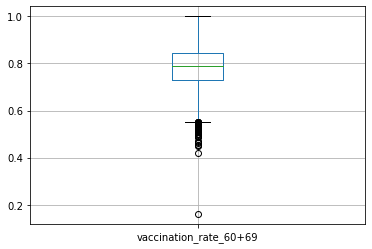

In [26]:
MSOA_fca.boxplot('vaccination_rate_60+69')

## Map plot code

In [27]:
# for Accessibility (continuous)
def access(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

In [28]:
# for Accessibility (natural break)
def access_break(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Accessibility', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessbility")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [29]:
# for Vaccination Rate (continuous)
def pop_rate(access_metric):
    base = MSOA_fca.plot(access_metric, legend = True, 
                         figsize = (10,10), 
                         cmap = "magma", 
                         markersize = .5, 
                         alpha = 1,
                         vmin = MSOA_fca[access_metric].quantile(0.05), vmax = MSOA_fca[access_metric].quantile(0.95))
    base.axis('off')
    base.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    #site.plot(ax=base, markersize=1, color='red')

In [30]:
# for Vaccination Rate (natural break)
def pop_rate_break(column):
    f,ax = plt.subplots(figsize=(10,10))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Vaccination Rate")

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [31]:
# Get the London boundary map for more conplex map plot 
# Read some London Boundary data for map show
# An intricate map of London's borders
borough = gpd.read_file('https://github.com/LingruFeng/0006_DSSS_assessment/blob/main/London_Boroughs.gpkg?raw=true')
borough = borough.to_crs('epsg:27700')
London = pd.merge(left = MSOA_fca, right=borough[['gss_code','objectid']],how = 'left', left_on='LA_Code_2020', right_on='gss_code')
London = London.dropna()
London['London'] = 'London'
London_boundary = London.dissolve(by='London')

# A rough map of the borders of London
inner=gpd.read_file('https://github.com/LingruFeng/i2p_assessment3/blob/main/inner_outer.gpkg?raw=true')
inner = inner.to_crs('epsg:27700')
inner = inner.dissolve(by='Source')

In [32]:
# for Vaccination Rate (break) with London zooming in
def pop_rate_break_1(column):
    f,ax = plt.subplots(figsize=(13,13))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    inner.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax)
    ax.axis('off') 
    ax.set_title('England Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title("Vaccination Rate")
    ax.get_legend().get_title().set_fontsize('15')
    
    ax.text(x=140000, y=590000, s='N', fontsize=30)
    ax.arrow(150000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    
    ax2 = f.add_axes([0.1, 0.35, 0.3, 0.3])
    MSOA_fca.plot(column=column,edgecolor='None', scheme='NaturalBreaks',k=7,legend=False,ax=ax2)
    ax2.set_xlim([502300,562800])
    ax2.set_ylim([154800,201800])
    ax2.set_title('London', fontdict={'fontsize':'20', 'fontweight':'3'})
    London_boundary.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax2)
    ax2.axis('off')

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [33]:
# for Vaccination accessibility (break) with London zooming in
def access_break_1(column):
    f,ax = plt.subplots(figsize=(13,13))
    MSOA_fca.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    inner.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax)
    ax.axis('off') 
    ax.set_title('England Vaccination Accessibility in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title("Accessibility")
    ax.get_legend().get_title().set_fontsize('15')
    
    ax.text(x=140000, y=590000, s='N', fontsize=30)
    ax.arrow(150000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    
    ax2 = f.add_axes([0.1, 0.35, 0.3, 0.3])
    MSOA_fca.plot(column=column,edgecolor='None', scheme='NaturalBreaks',k=7,legend=False,ax=ax2)
    ax2.set_xlim([502300,562800])
    ax2.set_ylim([154800,201800])
    ax2.set_title('London', fontdict={'fontsize':'20', 'fontweight':'3'})
    London_boundary.plot(edgecolor=(0.8, 0, 0,0.8), facecolor='none', linewidth=1, ax=ax2)
    ax2.axis('off')

    q = mc.NaturalBreaks(MSOA_fca[column], k=7)
    legendgram(f, ax, 
                MSOA_fca[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [34]:
# for London Vaccination Rate map only
def pop_rate_break_London(column):
    f,ax = plt.subplots(figsize=(10,10))
    London.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('London Vaccination Rate in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Vaccination Rate")

    q = mc.NaturalBreaks(London[column], k=7)
    legendgram(f, ax, 
                London[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

In [35]:
# for London accessibility map only
def access_break_London(column):
    f,ax = plt.subplots(figsize=(10,10))
    London.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    ax.set_title('London Vaccination Accessibility in 60-69 by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})

    ax.get_legend().set_title("Accessibility")

    q = mc.NaturalBreaks(London[column], k=7)
    legendgram(f, ax, 
                London[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

## Accessibility (When the service radius is 10/15/20/25/30 miles driving distance)

### 2SFCA

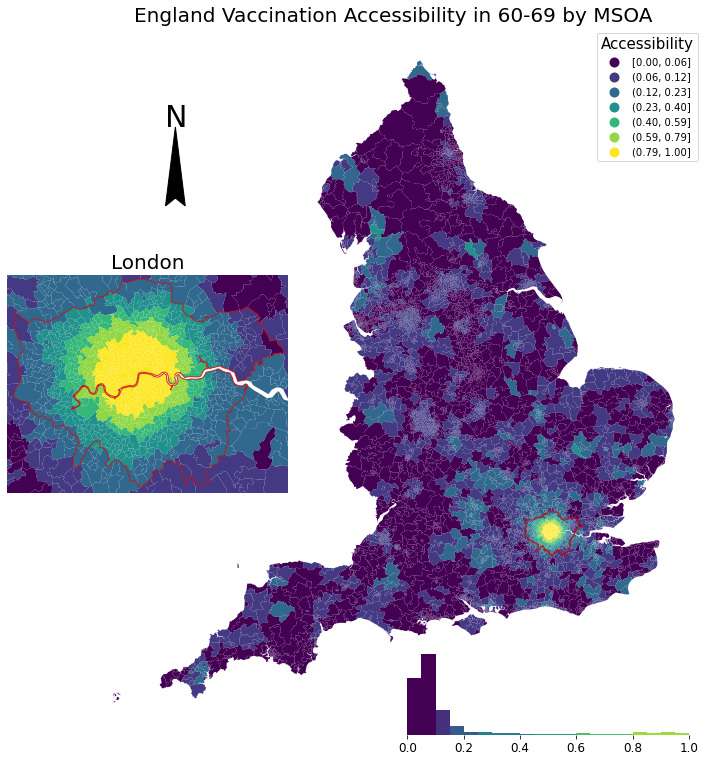

In [36]:
access_break_1('2sfca_10_normalized')

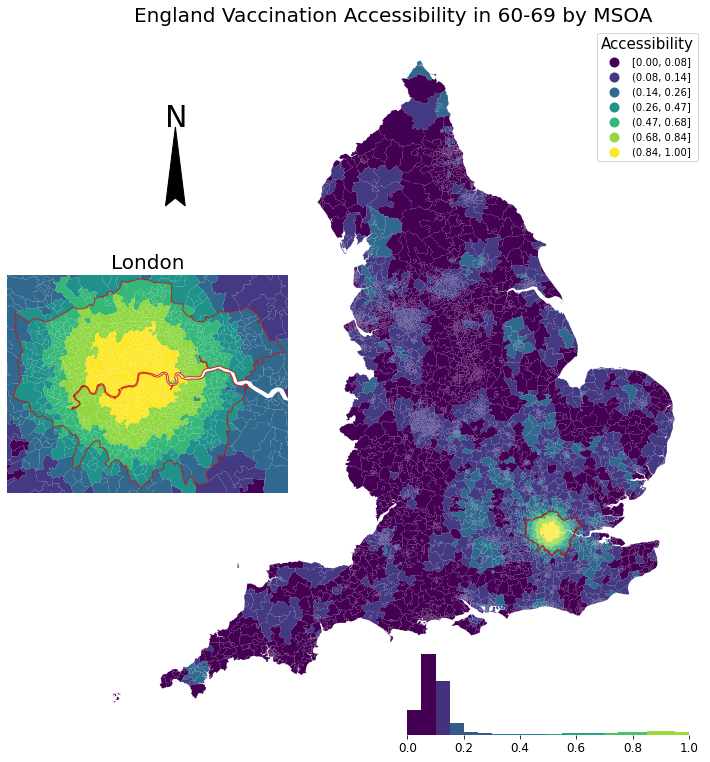

In [43]:
access_break_1('2sfca_15_normalized')

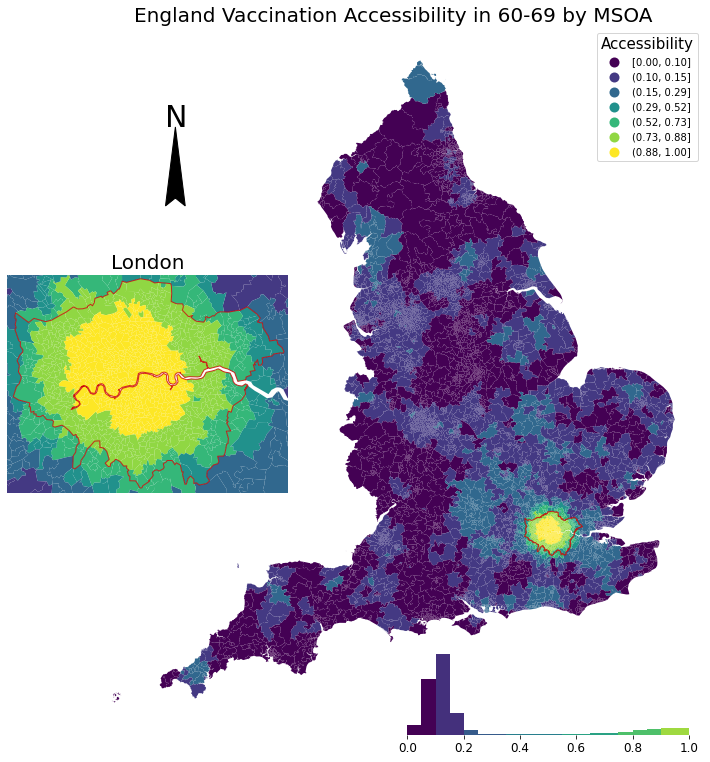

In [44]:
access_break_1('2sfca_20_normalized')

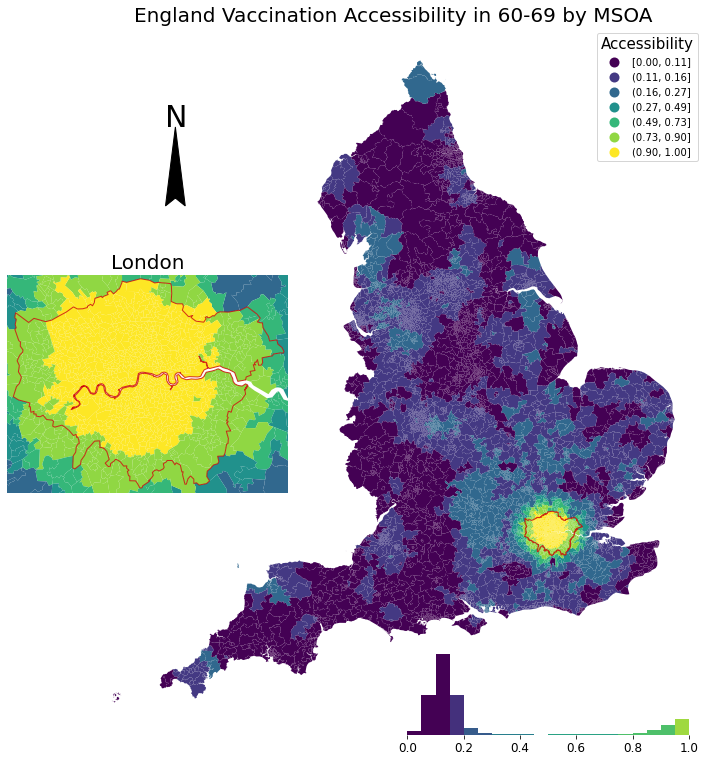

In [45]:
access_break_1('2sfca_25_normalized')

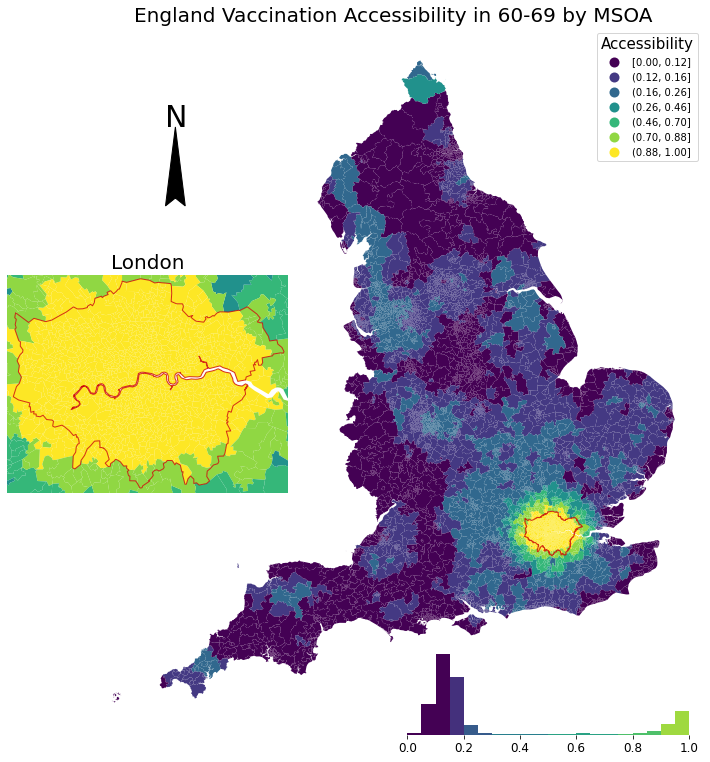

In [46]:
access_break_1('2sfca_30_normalized')

### E2SFCA

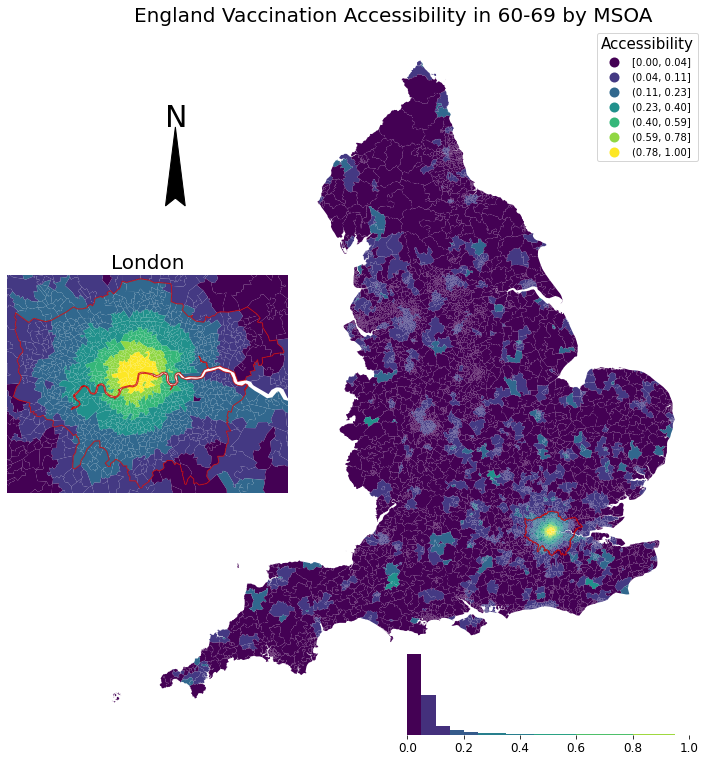

In [37]:
access_break_1('E2sfca_10_normalized')

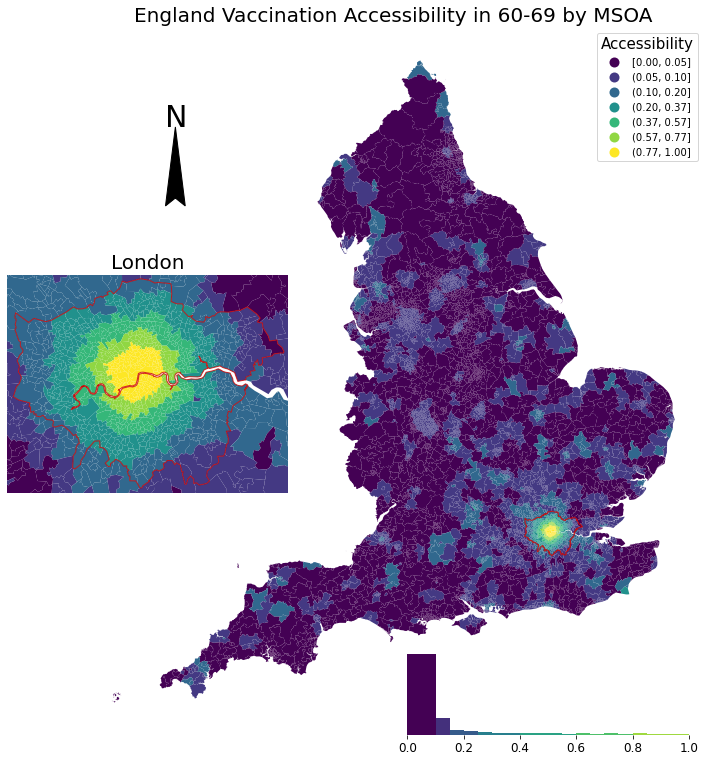

In [47]:
access_break_1('E2sfca_15_normalized')

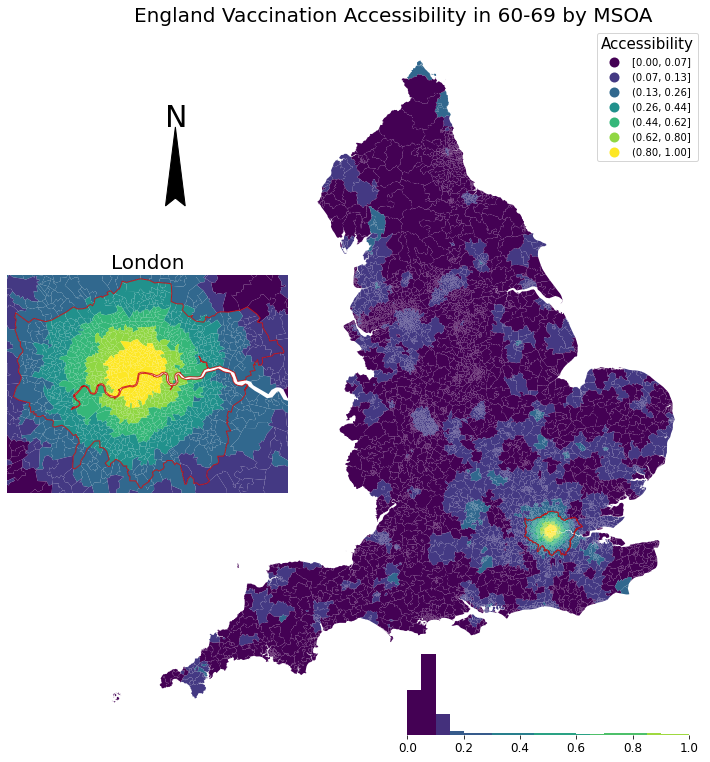

In [48]:
access_break_1('E2sfca_20_normalized')

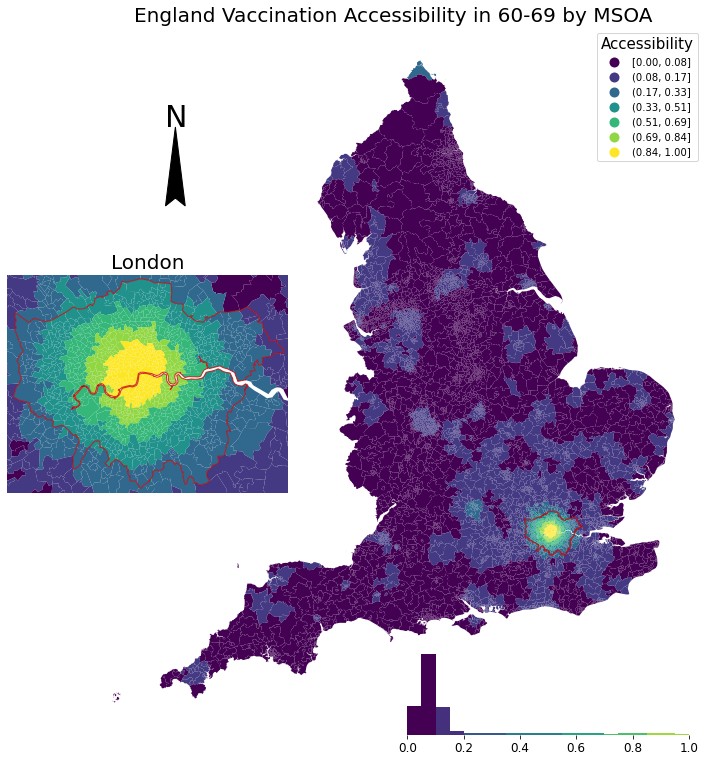

In [49]:
access_break_1('E2sfca_25_normalized')

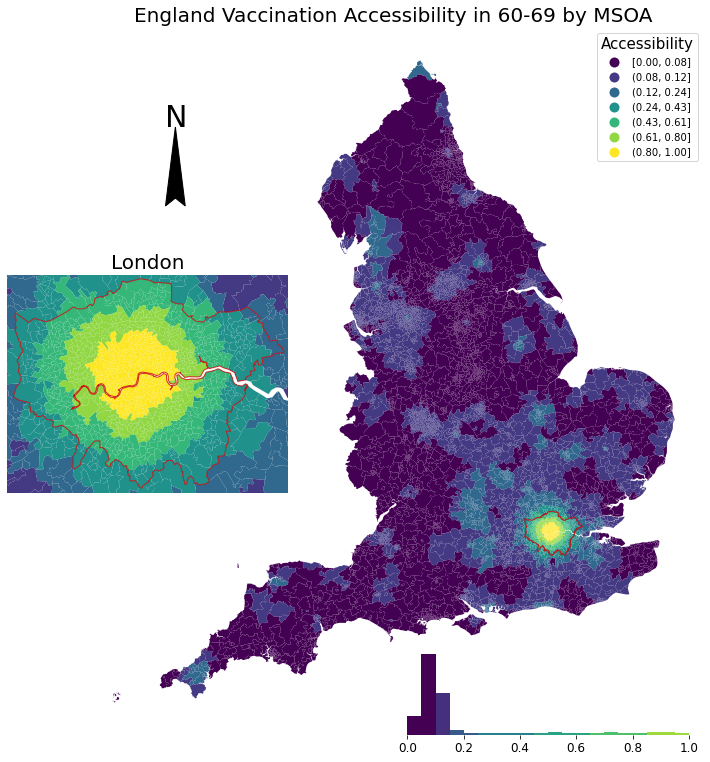

In [50]:
access_break_1('E2sfca_30_normalized')

### 3SFCA

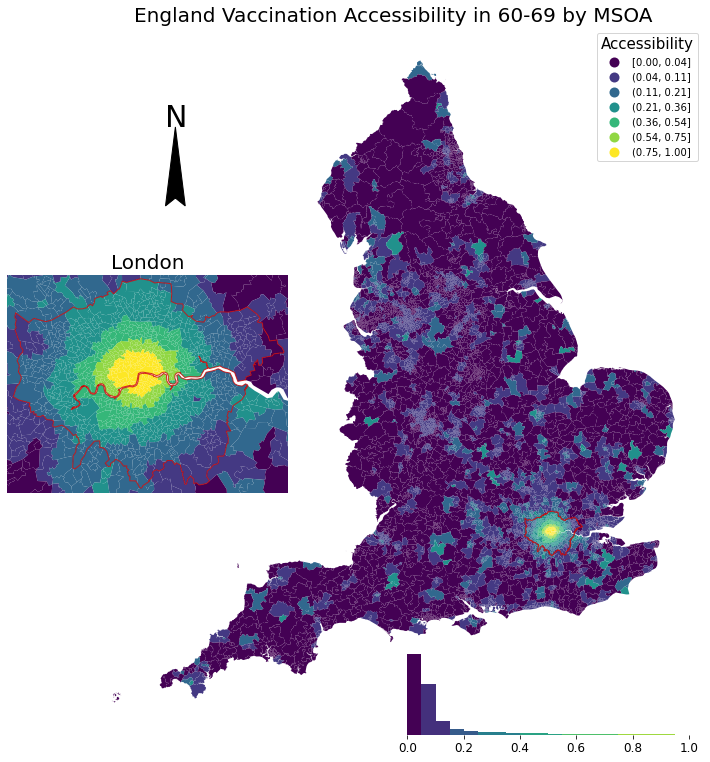

In [38]:
access_break_1('3sfca_10_normalized')

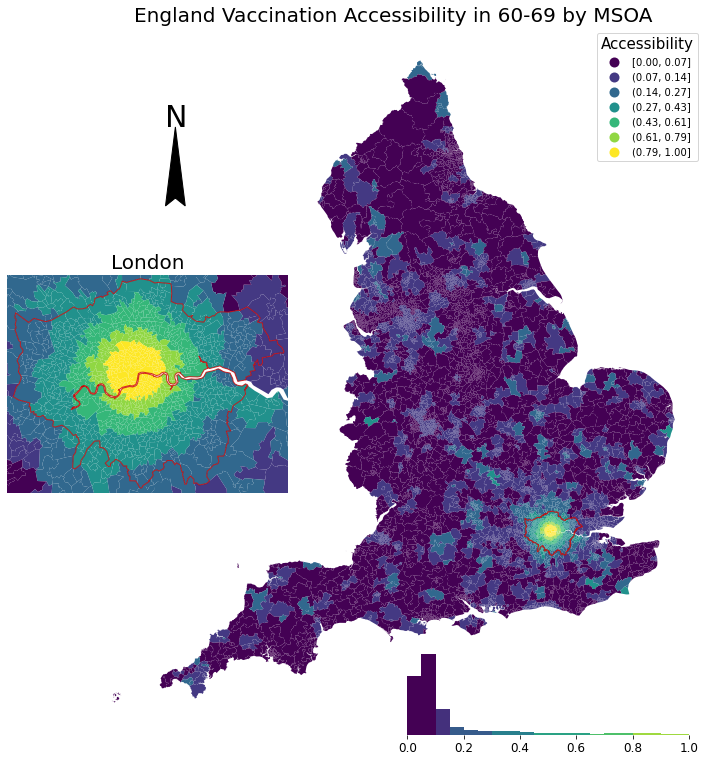

In [39]:
access_break_1('3sfca_15_normalized')

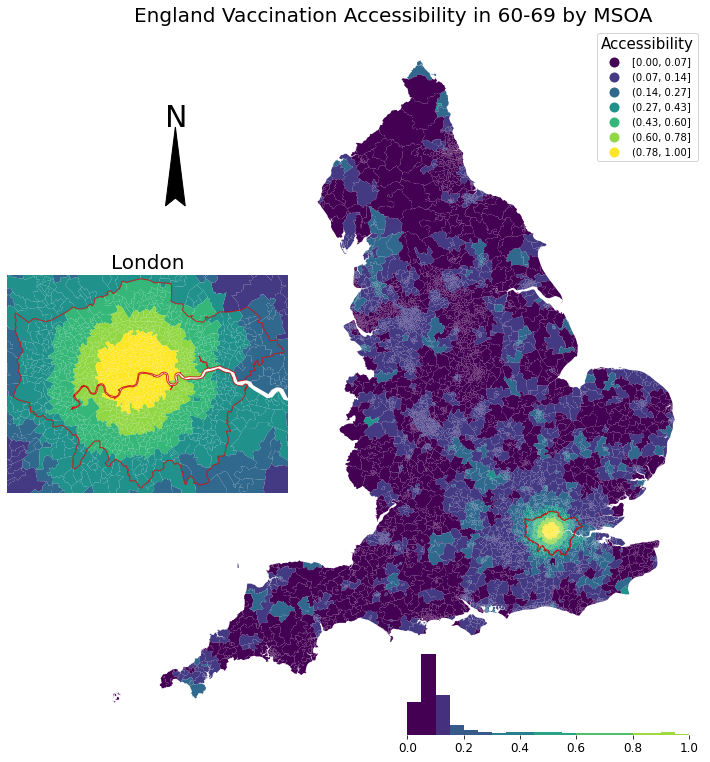

In [40]:
access_break_1('3sfca_20_normalized')

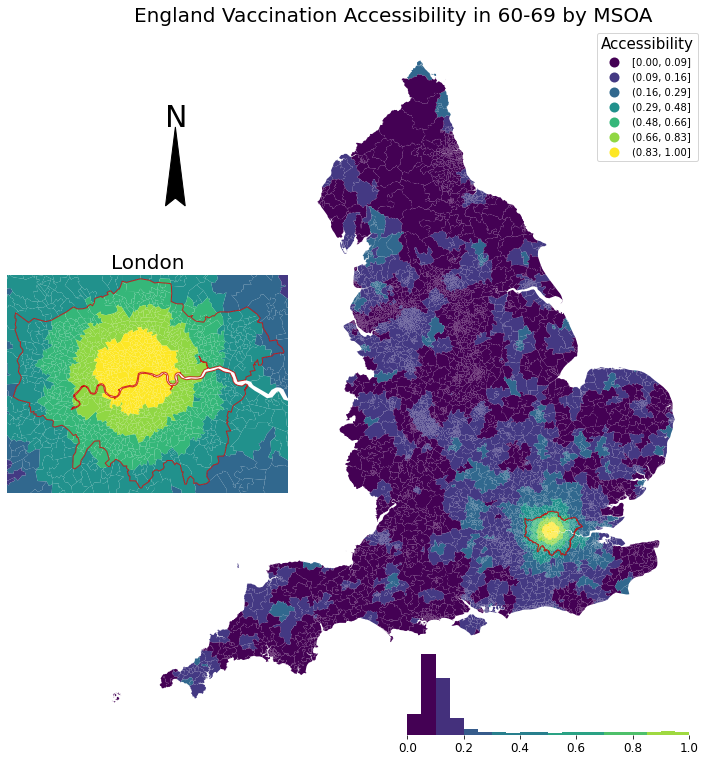

In [41]:
access_break_1('3sfca_25_normalized')

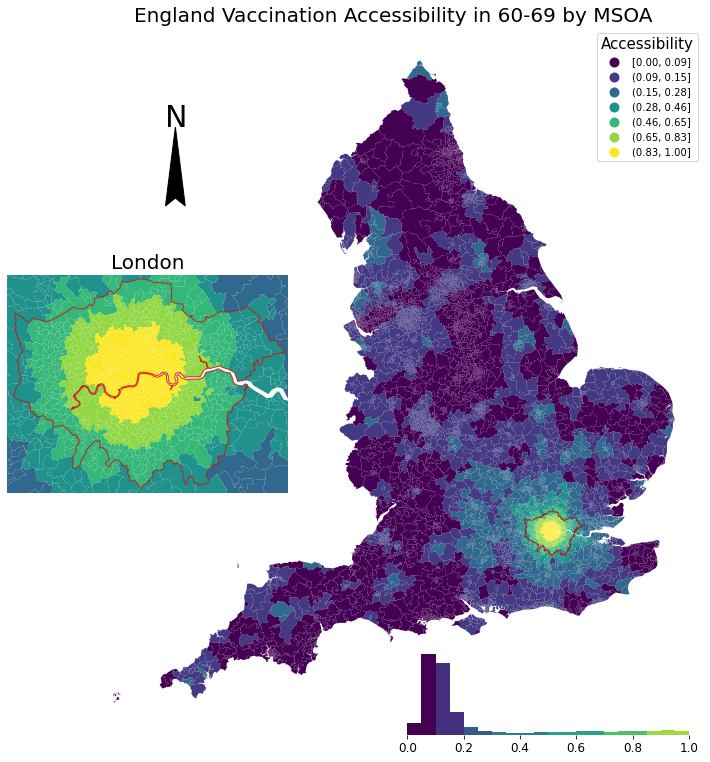

In [42]:
access_break_1('3sfca_30_normalized')

### RAAM

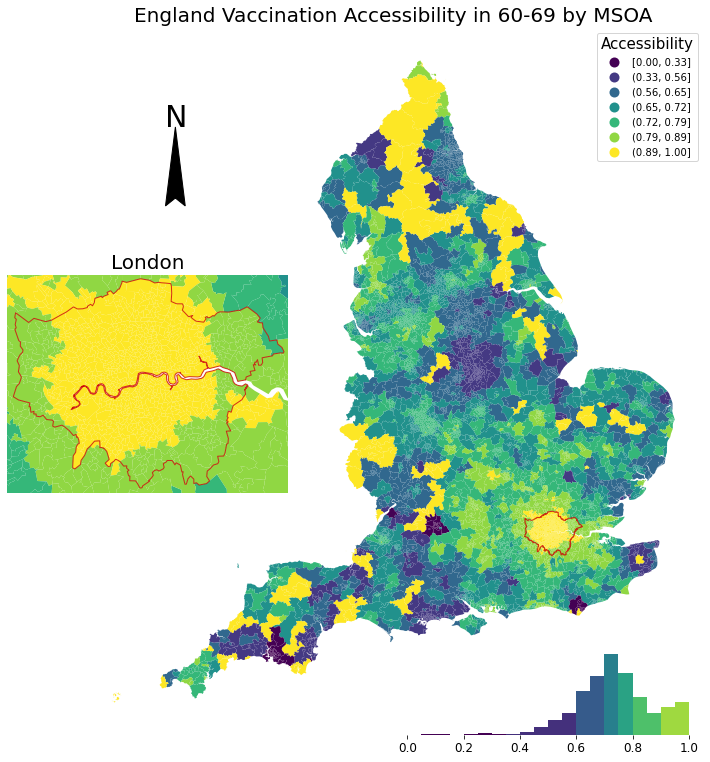

In [53]:
access_break_1('raam_inverse_normalize')

## Vaccination Rate

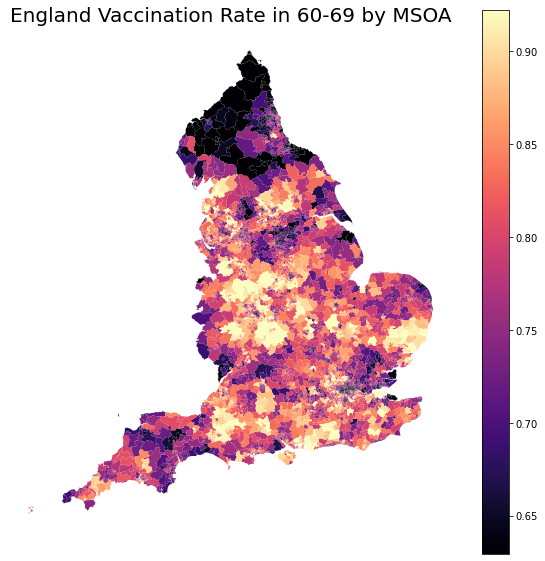

In [51]:
pop_rate('vaccination_rate_60+69')

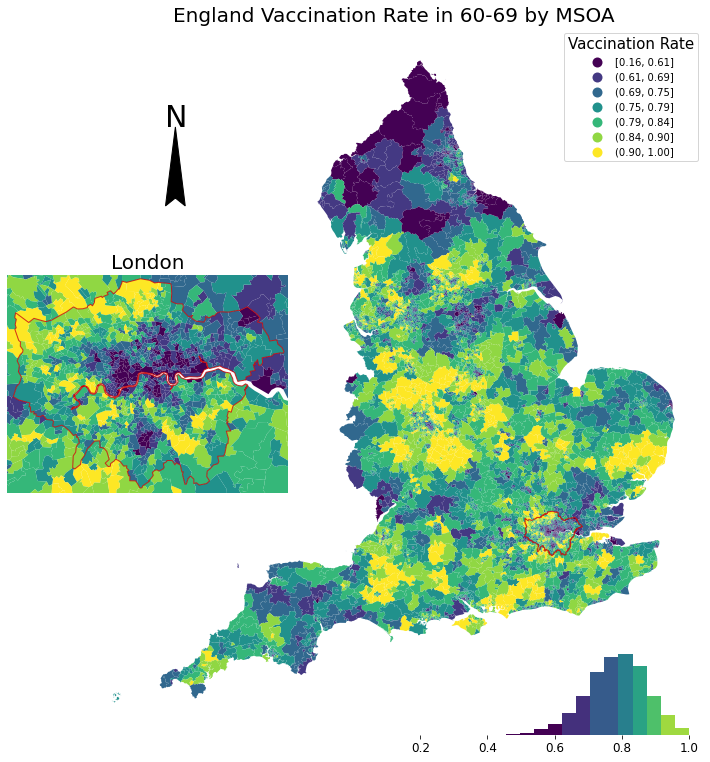

In [52]:
pop_rate_break_1('vaccination_rate_60+69')

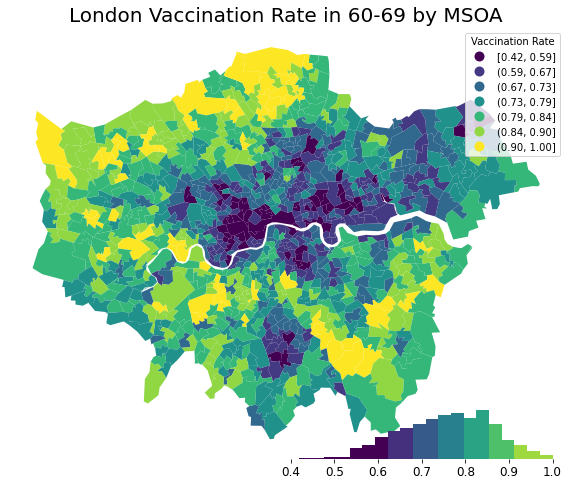

In [53]:
pop_rate_break_London('vaccination_rate_60+69')

# Calculate Pearson and Spearman correlation coefficient of accessibility and vaccination rate

### 2SFCA
#### 10mile

In [54]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.2056645924657765
p-value: 9.080615750385992e-66
Spearman correlation coefficient: -0.030699198738981946
p-value: 0.011407048730260912


#### 15 mile

In [55]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.16128160491642302
p-value: 8.349476908159204e-41
Spearman correlation coefficient: -0.01561154822595188
p-value: 0.19832073272177964


#### 20 mile

In [56]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.127665081494815
p-value: 4.476593467601255e-26
Spearman correlation coefficient: -0.018218655473778232
p-value: 0.133303194418481


#### 25 mile

In [57]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.11496600863019801
p-value: 2.0227842346256205e-21
Spearman correlation coefficient: -0.010651002198427956
p-value: 0.38016841040879357


#### 30 mile

In [58]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.10753864974764825
p-value: 6.326799547703783e-19
Spearman correlation coefficient: -0.008470285820881295
p-value: 0.48524016773173007


### E2SFCA

#### 10 mile

In [60]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.23448437804187316
p-value: 1.756823752071746e-85
Spearman correlation coefficient: -0.07267622834839745
p-value: 2.023675006924011e-09


#### 15 mile

In [61]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.22087349488946145
p-value: 8.081596412326752e-76
Spearman correlation coefficient: -0.05312478267208257
p-value: 1.185873184992651e-05


#### 20 mile

In [62]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.20358524824195187
p-value: 1.8699752567872876e-64
Spearman correlation coefficient: -0.038663525665723945
p-value: 0.0014387094301049463


#### 25 mile

In [63]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.18738884688750146
p-value: 1.033833699140086e-54
Spearman correlation coefficient: -0.02934912725621981
p-value: 0.015577593255113816


#### 30 mile

In [64]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['E2sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.17378647875929842
p-value: 3.4197103376337914e-47
Spearman correlation coefficient: -0.023744903517954705
p-value: 0.05038576728203233


### 3SFCA

#### 10 mile

In [65]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_10_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.21555167863716584
p-value: 3.259955972099287e-72
Spearman correlation coefficient: -0.05471133230118395
p-value: 6.44697112248013e-06


#### 15 mile

In [66]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_15_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.19489886171543822
p-value: 4.0226087470312e-59
Spearman correlation coefficient: -0.04383971254896196
p-value: 0.00030174828748077346


#### 20 mile

In [67]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_20_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.1787122640545214
p-value: 7.588535484071762e-50
Spearman correlation coefficient: -0.03793838097632875
p-value: 0.0017662504912761472


#### 25 mile

In [68]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_25_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.16757641353097744
p-value: 5.869574410418524e-44
Spearman correlation coefficient: -0.035451806799607195
p-value: 0.0034792975797188655


#### 30 mile

In [69]:
print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.pearsonr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])
print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[0])
print('p-value:', stats.spearmanr(MSOA_fca['3sfca_30_normalized'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.1599709569673608
p-value: 3.650217593143203e-40
Spearman correlation coefficient: -0.034658899339629755
p-value: 0.004283582873645781


### RAAM

In [63]:
#print('Pearson correlation coefficient:',stats.pearsonr(MSOA_fca['raam_inverse_normalize'], MSOA_fca['vaccination_rate_60+69'])[0])
#print('p-value:', stats.pearsonr(MSOA_fca['raam_inverse_normalize'], MSOA_fca['vaccination_rate_60+69'])[1])

Pearson correlation coefficient: -0.06709842719236428
p-value: 3.1187685649887144e-08


In [64]:
#print('Spearman correlation coefficient:',stats.spearmanr(MSOA_fca['raam_inverse_normalize'], MSOA_fca['vaccination_rate_60+69'])[0])
#print('p-value:', stats.spearmanr(MSOA_fca['raam_inverse_normalize'], MSOA_fca['vaccination_rate_60+69'])[1])

Spearman correlation coefficient: -0.03694426432062409
p-value: 0.0023270790197882888


# draw a scatter plot between accessibility and vaccination rate

In [70]:
def scatter_plot(accesstype):
    plot = pd.DataFrame()
    plot['Accessibility'] = MSOA_fca[accesstype]
    plot['Vaccination Rate'] = MSOA_fca['vaccination_rate_60+69']
    plt.style.use('ggplot')
    plt.figure(figsize=(10, 6))
    a = sns.scatterplot(data=plot, x="Accessibility", y="Vaccination Rate",s=10)
    a.axes.set_title("Scatter Plot Between Accessibility and Vaccination Rate",fontsize=20)
    a.set_xlabel("Accessibility",fontsize=15)
    a.set_ylabel("Vaccination Rate",fontsize=+15)

In [71]:
def pair(accesstype):
    plot = pd.DataFrame()
    plot['Accessibility'] = MSOA_fca[accesstype]
    plot['Vaccination Rate'] = MSOA_fca['vaccination_rate_60+69']
    g = sns.pairplot(plot,plot_kws={"s": 10})
    g.fig.set_size_inches(10,7)
    g.fig.suptitle("Pair Plot Between Accessibility and Vaccination Rate", y=1.05,x=0.55,fontsize=20)

### 2SFCA

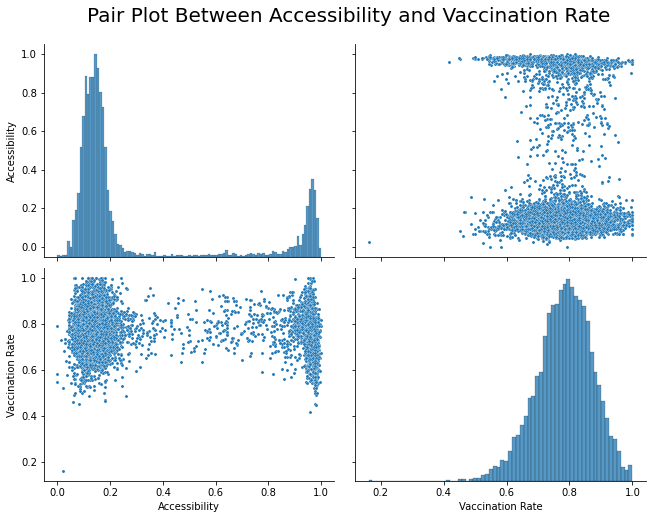

In [73]:
pair('2sfca_30_normalized')

### E2SFCA

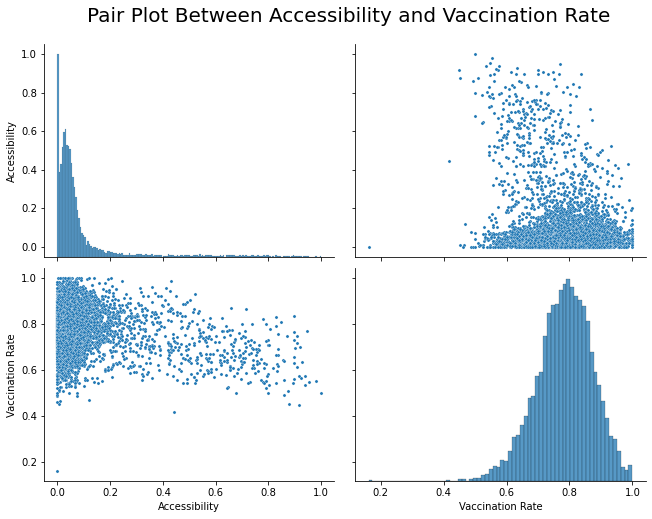

In [68]:
pair('E2sfca_normalized')

### 3SFCA

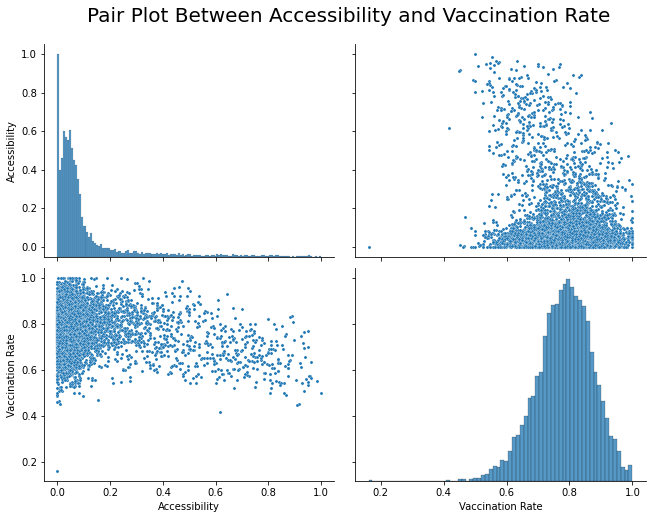

In [69]:
pair('3sfca_normalized')

### RAAM

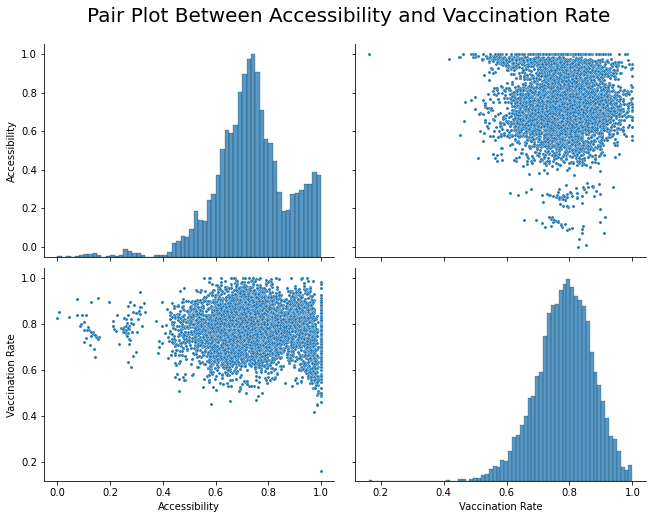

In [70]:
pair('raam_inverse_normalize')

In [55]:
#ax1 = plot.plot.scatter(x='Accessibility',
#                        y='Vaccination Rate',
#                        figsize = (10,6),
#                        fontsize = 15,s=10)
#plt.title("Scatter Plot between Accessibility and Vaccination Rate",fontsize=20)
#plt.xlabel("Accessibility",fontsize=15)
#plt.ylabel("Vaccination Rate",fontsize=15)